# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Pascal Tribel - [pascal.tribel@ulb.be](mailto:pascal.tribel@ulb.be)
### Cédric Simar - [cedric.simar@ulb.be](mailto:cedric.simar@ulb.be)
### Gian Marco Paldino - [gian.marco.paldino@ulb.be](mailto:gian.marco.paldino@ulb.be)

## TP 5 - Ensembles of models and feature selection

## Reminder:  Supervised learning

Supervised learning aims to model the (unknown) stochastic dependence between a set of $n$ inputs $x$ (also called features) and an output ${\mathbf y}$ on the basis of a training set $D_N$ of size $N$. Supervised learning tasks are decomposed into *regression* and *classification* tasks.
#### Regression
In regression the stochastic dependence is given by
$$ {\mathbf y} = f(x)+\mathbf{w}$$
where:
- $\mathbf{y} \in \mathbb{R}$ represents the output variable (also called target)
- $x \in \mathbb{R}^n$ represents the vector of inputs (also called features)
- $\mathbf{w}$ denotes the noise, and is typically assumed that $E[\mathbf{w}]=0$ and the variance 
 $\text{Var}[\mathbf{w}]=\sigma^2_{\mathbf{w}}$ is constant
- $f(x)=E[{\mathbf y} | x]$ is the (unknown) mapping between input and outputs, also known as the *regression function*.

In regression, the goal of learning is to return an estimator 
$$h(x,\alpha)$$
of the regression function $f(x)$, where $\alpha$ denotes the set of parameters of the model $h$.

## Error measurement
We already have used the _mean squared error_ as an evaluation tool for the quality of the predictions of a model. Unfortunately, this tool does not take into account how "variable" the expected outputs are, and therefore two models could become undistinguishable when using the MSE. We can normalize the MSE by dividing it by the (measured) variance of the output data. This leads to the _normalized mean squared error_:

$$\text{NMSE} = \frac{\sum(y-\hat{y})^2}{N\sigma^2_y}$$

We can see that the most naive model which outputs the mean of the observed outputs should give:
$$\frac{\sum(y-\mu_y)^2}{N\sigma^2_y} = \frac{\sigma^2_y}{\sigma^2_y} = 1$$

Any model that has a NMSE greater than $1$ is therefore performing worse than the most naive model. 

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

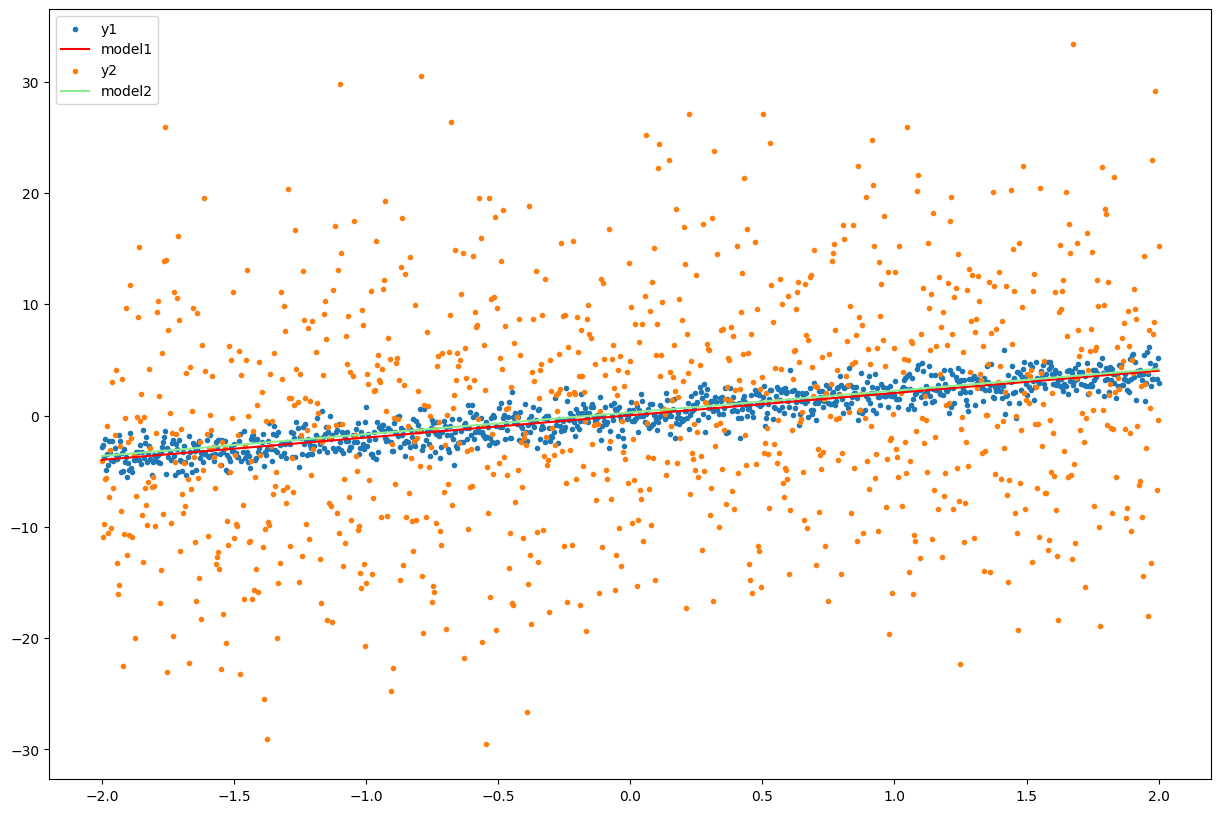

In [2]:
from sklearn.linear_model import LinearRegression
x = np.linspace(-2, 2, 1000).reshape(1000,-1)
B1, B2 = np.random.normal(0, 1, size=(1000,1)), np.random.normal(0, 10, size=(1000,1))
A = 2
y1 = A*x+B1
y2 = A*x+B2

model1 = LinearRegression().fit(x, y1)
model2 = LinearRegression().fit(x, y2)

plt.figure(figsize=(15, 10))
plt.scatter(x, y1, marker='.', label='y1')
plt.plot(x, model1.predict(x), color='red', label='model1')
plt.scatter(x, y2, marker='.', label='y2')
plt.plot(x, model2.predict(x), color='lightgreen', label='model2')
plt.legend()
plt.show()

In [3]:
def mse(y, y_hat):
    return np.mean((y-y_hat)**2)

def nmse(y, y_hat):
    return np.mean((y-y_hat)**2)/np.std(y)**2

In [4]:
print(f"MSEs: {mse(y1, model1.predict(x))}, {mse(y2, model2.predict(x))}")
print(f"NMSEs: {nmse(y1, model1.predict(x))}, {nmse(y2, model2.predict(x))}")

MSEs: 1.048699812743066, 96.7384381652006
NMSEs: 0.16365570622479042, 0.9499165399433076


## Feature selection
Feature selection and ensembles of models are two techniques which can be used to improve the accuracy of predictions.

Feature selection aims at reducing the dimensionality of the problem, and is useful when input variables contain redundant or irrelevant (noisy) information. Benefits are twofold: it decreases the training time by simplifying the problem, and it decreases the complexity of the predictive model. This in turn usually improves the prediction accuracy, since high-dimensionality makes predictive models more prone to overfitting, and estimates of parameters more variant.

There are three main approaches to feature selection:
- **Filter methods:** 
These methods rely solely on the data and their intrinsic properties, without considering the impact of the selected features on the learning algorithm performance. For this reason, they are often used as preprocessing techniques.

- **Wrapper methods:** 
These methods assess subsets of variables according to their usefulness to a given predictor. The feature selection is performed using an evaluation function that includes the predictive performance of the considered learning algorithm as a selection criterion.

- **Embedded methods:** 
These methods are specific to given learning machines, and usually built-in in the learning procedure (e.g. random forest, regularization based techniques).

Ensembles of models consist in building several predictive models using resampled subsets of the original training set. The method works particularly well for predictive models with high variance (for example, decision trees or neural networks). The average prediction of the resulting models usually strongly decreases the variance component of the error, and as a consequence improves the prediction accuracy.

In this session, we will use a synthetic dataset, made of 30 continuous variables. 24 of them will be useless, and 6 will serve in the output. The output will be a function of the useful input variables.

#### Data overview and preprocessing

In [42]:
def compute(data):
    data['y'] = np.zeros(data.shape[0])
    for i in range(6):
        if i%3 == 0:
            data['y'] += np.random.uniform(-1, 1) * data[f'x_useful_{i+1}'] + np.random.uniform(-5, 5)
        elif i%3 == 1:
            data['y'] += np.random.uniform(-1, 1) * data[f'x_useful_{i+1}']**2 + np.random.uniform(-5, 5)
        elif i%3 == 2:
            data['y'] += np.random.uniform(-1, 1) * np.sin(data[f'x_useful_{i+1}']) + np.random.uniform(-5, 5)
    return data

In [43]:
n_x_useful = 6
n_x_useless = 24
n_samples = 1000
d = {}
np.random.seed(0)

for i in range(n_x_useful):
    m, s = np.random.uniform(-1, 1), np.random.uniform(0.5, 2.5)
    d[f'x_useful_{i+1}'] = np.random.normal(m, s, size=(n_samples,))
for i in range(n_x_useless):
    m, s = np.random.uniform(-1, 1), np.random.uniform(0.5, 2.5)
    d[f'x_useless_{i+1}'] = np.random.normal(m, s, size=(n_samples,))

data = pd.DataFrame(d)

data = compute(data)

In [44]:
data.describe(include='all')

,x_useful_1,x_useful_2,x_useful_3,x_useful_4,x_useful_5,x_useful_6,x_useless_1,x_useless_2,x_useless_3,x_useless_4,...,x_useless_16,x_useless_17,x_useless_18,x_useless_19,x_useless_20,x_useless_21,x_useless_22,x_useless_23,x_useless_24,y
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.008883,0.787868,-0.862362,-0.220739,0.900991,0.048531,0.848947,0.019645,0.655122,-0.189598,...,-0.421467,0.821257,-0.011411,0.441756,-0.958489,-0.384471,-0.152625,-0.518022,0.051116,-7.379040
std,1.904117,2.362233,1.466222,0.881817,1.535395,0.512844,1.362313,1.729953,1.665836,0.771923,...,0.922338,0.862039,2.287231,1.402679,1.452495,0.787796,0.610938,2.501076,1.985946,1.890504
min,-5.782583,-6.520188,-5.587836,-3.444757,-3.751236,-1.380297,-3.305645,-5.469208,-4.426479,-2.355184,...,-3.443265,-1.763982,-7.985982,-4.070035,-5.422766,-2.947481,-1.917751,-11.958636,-6.453296,-13.989287
25%,-1.250588,-0.839990,-1.910921,-0.821390,-0.111143,-0.293415,-0.091018,-1.090598,-0.432532,-0.738497,...,-1.025653,0.250196,-1.464619,-0.527079,-1.967275,-0.890462,-0.564771,-2.155428,-1.329528,-8.514752
50%,-0.014389,0.822298,-0.868373,-0.229933,0.883910,0.050555,0.825699,0.014043,0.655699,-0.199494,...,-0.423784,0.844540,0.021261,0.423711,-1.010335,-0.403122,-0.147460,-0.412912,0.054168,-7.414389
75%,1.269272,2.284124,0.175776,0.372973,1.957939,0.386908,1.786537,1.128925,1.744190,0.350852,...,0.211144,1.361641,1.522601,1.368873,0.002406,0.173736,0.252462,1.202683,1.373122,-6.287151
max,5.424227,8.481613,3.712036,3.085683,5.435128,1.539755,4.825280,5.912388,5.919659,2.026439,...,3.010346,4.035696,7.689106,5.682900,3.504355,2.146540,1.745356,8.160750,5.685927,2.202998


### Input and output variables

The output variable (Y) is `y`, and all other variables (X) are considered as inputs.

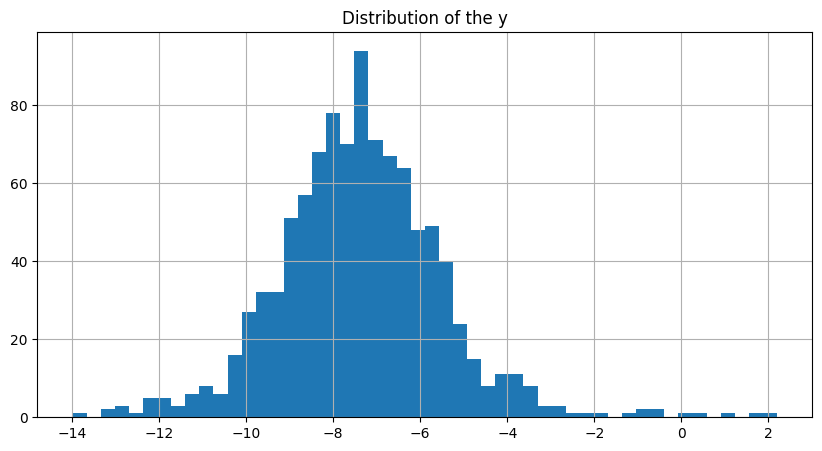

Mean of Y: -7.379040070934719
Variance of Y: 3.5704323990926374


In [45]:
Y = data['y'].values
X = data.drop(columns=['y'])

N = X.shape[0]
n = X.shape[1]

plt.figure(figsize=(10, 5))
plt.hist(Y, bins=50)
plt.title("Distribution of the y")
plt.grid()
plt.show()

print("Mean of Y:", np.mean(Y))
print("Variance of Y:", np.var(Y))

### 1) Modelling with linear and decision tree models

#### Linear model

* Create a linear model $h(x)$ for predicting the IMDB score on the basis of the input variables, and compute its empirical (or training) mean square error.

In [46]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, Y)
Y_hat = model.predict(X)

empirical_error = nmse(Y, Y_hat)
print(f"Empirical error: {empirical_error:.5f}")

Empirical error: 0.55375


* Which input variables are statistically correlated with the output?

In Python, we can check the coefficients of the linear model.

In [47]:
coefs = pd.Series(model.coef_, index=X.columns)
coefs

x_useful_1     -0.201436
x_useful_2      0.245148
x_useful_3     -0.136977
x_useful_4      0.899940
x_useful_5     -0.392151
x_useful_6     -0.152609
x_useless_1     0.066708
x_useless_2     0.017732
x_useless_3     0.002349
x_useless_4    -0.035563
x_useless_5    -0.051568
x_useless_6     0.016830
x_useless_7    -0.028055
x_useless_8     0.021751
x_useless_9     0.031762
x_useless_10   -0.014019
x_useless_11   -0.002496
x_useless_12    0.066974
x_useless_13   -0.002970
x_useless_14    0.027713
x_useless_15   -0.003320
x_useless_16    0.004007
x_useless_17   -0.033228
x_useless_18    0.032634
x_useless_19   -0.011024
x_useless_20    0.015800
x_useless_21    0.044646
x_useless_22   -0.107929
x_useless_23    0.005993
x_useless_24    0.003837
dtype: float64

* Compute the validation error with a 10-fold cross-validation

In [48]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=3)
CV_err_lm_single_model = []

for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    model = LinearRegression()
    model.fit(X_tr, Y_tr)
    Y_hat_ts = model.predict(X_ts)
    CV_err_lm_single_model.append(nmse(Y_ts, Y_hat_ts))

print(f"CV error: {np.mean(CV_err_lm_single_model):.5f}, std dev: {np.std(CV_err_lm_single_model):.5f}")

CV error: 0.61060, std dev: 0.08403


#### Decision tree

* Modify the previous code to compute the empirical error using a decision tree model. Use sklearn's `DecisionTreeRegressor`.

In [49]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=3)
model.fit(X, Y)
Y_hat = model.predict(X)

empirical_error = nmse(Y, Y_hat)
print(f"Empirical error: {empirical_error:.5f}")

Empirical error: 0.00000


* Plot the resulting tree is more complicated in Python due to size, but we can just visualize its structure or get the depth.

In [50]:
model.get_depth(), model.get_n_leaves()

(22, 1000)

* What is the 10-fold cross-validation error using a decision tree model?

In [51]:
CV_err_rpart_single_model = []

for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    model = DecisionTreeRegressor(random_state=3)
    model.fit(X_tr, Y_tr)
    Y_hat_ts = model.predict(X_ts)
    CV_err_rpart_single_model.append(nmse(Y_ts, Y_hat_ts))

print(f"CV error: {np.mean(CV_err_rpart_single_model):.5f}, std dev: {np.std(CV_err_rpart_single_model):.5f}")

CV error: 0.33924, std dev: 0.08885


Why is the result so different using the 10-fold cross-validation?

#### Ridge regression with LOO-CV
Recall: Ridge regression looks like a linear regression but includes a penalty term for large coefficients:
$$
  \min_{\beta} \;\; \| Y - X \beta \|^2 + \lambda \| \beta \|^2.
$$


Ridge also has a known closed-form:
$$
  \hat{\beta}_{\mathrm{ridge}} = (X^\top X + \lambda I)^{-1} X^\top Y.
$$

* Leave-one out cross-validation is a method that consists in evaluating a given model by training it on the entire training set, except for one sample used for validation. By performing this validation, eliminating each of the samples at a time, we get an estimation of the quality of the model.
* Then, the coefficients can give an idea of the importance of each of the features in the prediction task.

Best lambda: 0.17333333333333334
Greatests coefficients indexes: [0 4 5 2]
Greatests coefficients: [-7.09953353  0.90007894 -0.39262165  0.24499269]


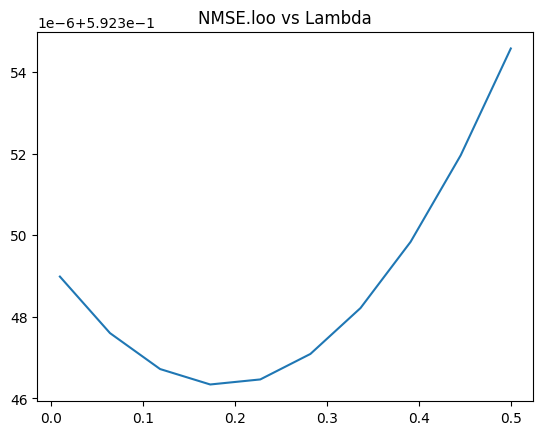

In [55]:
X_np = X.to_numpy()

N = X_np.shape[0]
lambdas = np.linspace(0.01, 0.5, 10)
E = np.empty((N, len(lambdas)))  
E[:] = np.nan

for i in range(N):
    Xtr = np.column_stack((np.ones(N - 1), np.delete(X_np, i, axis=0)))
    Ytr = np.delete(Y, i)
    
    Xts = np.concatenate(([1], X_np[i,]))
    
    cnt = 0
    for l in lambdas:
        A = Xtr.T @ Xtr + l * np.eye(n + 1)
        b = Xtr.T @ Ytr
        betahat = np.linalg.inv(A) @ b
        Yhati = Xts @ betahat
        E[i, cnt] = ((Y[i] - Yhati) ** 2)
        cnt += 1

mseloo = np.mean(E, axis=0)/np.std(Y)**2

bestLambda = lambdas[np.argmin(np.mean(E, axis=0))]
print(f"Best lambda: {bestLambda}")

XX = np.column_stack((np.ones(N), X_np))
A_final = np.dot(XX.T, XX) + bestLambda * np.eye(n + 1)
b_final = np.dot(XX.T, Y)
betahat = np.linalg.inv(A_final) @ XX.T @ Y

abs_betahat = np.abs(betahat)
sorted_indices = np.argsort(-abs_betahat)
top4 = sorted_indices[:4] 
print(f"Greatests coefficients indexes: {top4}")
print(f"Greatests coefficients: {betahat[top4]}")
plt.plot(lambdas, mseloo)
plt.title('NMSE.loo vs Lambda')
plt.show()

#### Selection bias
Take care that if the features are selected using the error on the training set as an importance criterium leads to a flaw: the features may be over-fittingly selected and the performances then do not reflect on the testing performances dataset.

In [56]:
from tqdm.auto import tqdm

  0%|          | 0/15 [00:00<?, ?it/s]

[2, 5, 4, 1, 16, 26, 8, 19, 25, 3, 9, 14, 10, 21, 23]
[0.38024814 0.18601574 0.03416394 0.11646339 0.24992521 0.25166889
 0.30676086 0.25453182 0.21373667 0.26682242 0.27984623 0.12270375
 0.30872385 0.37119992 0.38948186]


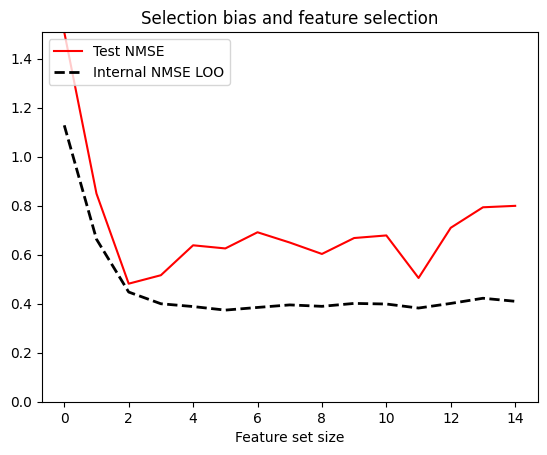

In [75]:
def pred(X_train, Y_train, X_test):
   reg = sklearn.tree.DecisionTreeRegressor().fit(X_train, Y_train)
   return reg.predict(X_test)

X_tr = X.to_numpy()[:200]
Y_tr = Y[:200]
X_ts = X.to_numpy()[200:250]
Y_ts = Y[200:250]

N_tr = X_tr.shape[0]

fset = []
bestr = []
bests = []

for it in tqdm(range(15)):
    NMSEf = {}
    candidates = [f for f in range(n) if f not in fset]
    for f in candidates:
        e = np.empty(N_tr)
        for i in range(N_tr):
            X_train_all = np.delete(X_tr, i, axis=0)
            Y_train_all = np.delete(Y_tr, i) 
            cols = [j - 1 for j in (fset + [f])]
            X_train = X_train_all[:, cols]
            X_test_sample = X_tr[i, cols]
            Yhati = pred(X_train, Y_train_all, X_test_sample.reshape(1, -1))
            e[i] = (Y[i] - Yhati)**2/np.std(Y_tr)**2
        NMSEf[f] = np.mean(e)
    f_best = min(NMSEf, key=NMSEf.get)
    fset.append(f_best)
    bestr.append(NMSEf[f_best])
    cols = [j - 1 for j in fset]
    Y_hats = pred(X_tr[:, cols], Y_tr, X_ts[:, cols])
    nmse_test = nmse(Y_hats, Y_ts)
    bests.append(nmse_test) 
print(fset)
print(np.array(bests) - np.array(bestr))
plt.plot(bests, color="red", label="Test NMSE")
plt.plot(bestr, linestyle="--", linewidth=2, color="black", label="Internal NMSE LOO")
plt.ylim(0, max(bests))
plt.title("Selection bias and feature selection")
plt.xlabel("Feature set size")
plt.ylabel("")
plt.legend(loc="upper left")
plt.show()

## 2) Ensemble of models

Let us now create an ensemble of R=20 linear models to make predictions.
* Use a linear model as the base model.

In [58]:
R = 20
CV_err_lm_ensemble_model = []

for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    Y_hat_ts_ensemble = np.zeros((X_ts.shape[0], R))
    for r in range(R):
        idx_tr_resample = np.random.choice(train_index, size=len(train_index), replace=True)
        X_tr_res = X.iloc[idx_tr_resample]
        Y_tr_res = Y[idx_tr_resample]
        
        model = LinearRegression()
        model.fit(X_tr_res, Y_tr_res)
        Y_hat_ts_ensemble[:, r] = model.predict(X_ts)
    
    Y_hat_ts = np.mean(Y_hat_ts_ensemble, axis=1)
    CV_err_lm_ensemble_model.append(nmse(Y_ts, Y_hat_ts))

print(f"CV error: {np.mean(CV_err_lm_ensemble_model):.5f}, std dev: {np.std(CV_err_lm_ensemble_model):.5f}")
print("Is ensemble error lower than single model?", np.mean(CV_err_lm_ensemble_model) < np.mean(CV_err_lm_single_model))

CV error: 0.61130, std dev: 0.08462
Is ensemble error lower than single model? False


* Use a decision tree as the base model. Is the CV error lower?

In [59]:
R = 20
CV_err_rpart_ensemble_model = []

for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    Y_hat_ts_ensemble = np.zeros((X_ts.shape[0], R))
    for r in range(R):
        idx_tr_resample = np.random.choice(train_index, size=len(train_index), replace=True)
        X_tr_res = X.iloc[idx_tr_resample]
        Y_tr_res = Y[idx_tr_resample]
        
        model = DecisionTreeRegressor(random_state=r)
        model.fit(X_tr_res, Y_tr_res)
        Y_hat_ts_ensemble[:, r] = model.predict(X_ts)
    
    Y_hat_ts = np.mean(Y_hat_ts_ensemble, axis=1)
    CV_err_rpart_ensemble_model.append(nmse(Y_ts, Y_hat_ts))

print(f"CV error: {np.mean(CV_err_rpart_ensemble_model):.5f}, std dev: {np.std(CV_err_rpart_ensemble_model):.5f}")
print("Is ensemble error lower than single model?", np.mean(CV_err_rpart_ensemble_model) < np.mean(CV_err_rpart_single_model))

CV error: 0.16278, std dev: 0.03429
Is ensemble error lower than single model? True


## 3) Feature selection

### Filter methods

#### Correlation with the output

The following code performs feature selection by keeping the most correlated variables with the output. Compare the results for linear models and decision trees. What are the smallest CV errors, and how many features were needed?

In [60]:
correlations = np.abs(X.corrwith(pd.Series(Y)))
ranking_corr_idx = correlations.sort_values(ascending=False).index

CV_err = np.zeros((n,10))

fold_id = 0
for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    for nb_features in range(1, n+1):
        selected_features = ranking_corr_idx[:nb_features]
        model = LinearRegression()
        model.fit(X_tr[selected_features], Y_tr)
        Y_hat_ts = model.predict(X_ts[selected_features])
        CV_err[nb_features-1, fold_id] = nmse(Y_ts, Y_hat_ts)
    fold_id += 1

for i in range(n):
    print("#Features:", i+1, "; CV error=", round(np.mean(CV_err[i,:]),4),
          "; std dev=", round(np.std(CV_err[i,:]),4))

print("Correlation ranking:")
print(ranking_corr_idx.tolist())

#Features: 1 ; CV error= 0.8381 ; std dev= 0.0698
#Features: 2 ; CV error= 0.7428 ; std dev= 0.0702
#Features: 3 ; CV error= 0.653 ; std dev= 0.093
#Features: 4 ; CV error= 0.607 ; std dev= 0.0841
#Features: 5 ; CV error= 0.5946 ; std dev= 0.0848
#Features: 6 ; CV error= 0.5957 ; std dev= 0.0857
#Features: 7 ; CV error= 0.5952 ; std dev= 0.0871
#Features: 8 ; CV error= 0.5958 ; std dev= 0.0894
#Features: 9 ; CV error= 0.5943 ; std dev= 0.0903
#Features: 10 ; CV error= 0.5936 ; std dev= 0.0867
#Features: 11 ; CV error= 0.5944 ; std dev= 0.0867
#Features: 12 ; CV error= 0.595 ; std dev= 0.0869
#Features: 13 ; CV error= 0.5958 ; std dev= 0.0865
#Features: 14 ; CV error= 0.5966 ; std dev= 0.0857
#Features: 15 ; CV error= 0.5976 ; std dev= 0.0874
#Features: 16 ; CV error= 0.5984 ; std dev= 0.0876
#Features: 17 ; CV error= 0.5999 ; std dev= 0.0865
#Features: 18 ; CV error= 0.6009 ; std dev= 0.0865
#Features: 19 ; CV error= 0.601 ; std dev= 0.0864
#Features: 20 ; CV error= 0.6017 ; std dev= 0

#### mRMR

We will implement a simple mRMR feature selection. mRMR uses mutual information. We will approximate mutual information via the correlation-based formula provided.

In [61]:
def mutual_info_corr(X, Y):
    c = np.corrcoef(X, Y)[0,1]
    # Avoid invalid value if correlation == 1 or == -1
    if abs(c)==1:
        c = 0.999999
    return -0.5 * np.log(1 - c**2)

def compute_mi_vector(X_tr, Y_tr):
    mis = []
    for col in X_tr.columns:
        mi = mutual_info_corr(X_tr[col].values, Y_tr)
        mis.append(mi)
    return np.array(mis)

CV_err = np.zeros((n,10))

fold_id = 0
for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    mutual_info_values = compute_mi_vector(X_tr, Y_tr)
    selected = []
    candidates = list(range(n))
    
    for j in range(n):
        redundancy_score = np.zeros(len(candidates))
        if len(selected)>0:
            # Compute pairwise mi between selected and candidates
            mi_sc = []
            for cidx in candidates:
                col_c = X_tr.iloc[:, cidx]
                mis_c = []
                for sidx in selected:
                    col_s = X_tr.iloc[:, sidx]
                    # Compute mutual info between col_s and col_c
                    cc = np.corrcoef(col_s, col_c)[0,1]
                    if abs(cc)==1:
                        cc=0.999999
                    mis_c.append(-0.5*np.log(1-cc**2))
                redundancy_score[candidates.index(cidx)] = np.mean(mis_c)
        mRMR_score = mutual_info_values[candidates] - redundancy_score
        best_idx = candidates[np.argmax(mRMR_score)]
        selected.append(best_idx)
        candidates.remove(best_idx)
    
    # selected is the ranking
    for nb_features in range(1, n+1):
        features_to_use = [X.columns[i] for i in selected[:nb_features]]
        model = LinearRegression()
        model.fit(X_tr[features_to_use], Y_tr)
        Y_hat_ts = model.predict(X_ts[features_to_use])
        CV_err[nb_features-1, fold_id] = nmse(Y_ts, Y_hat_ts)
    fold_id += 1

for i in range(n):
    print("#Features:", i+1, "; CV error=", round(np.mean(CV_err[i,:]),4),
          "; std dev=", round(np.std(CV_err[i,:]),4))
    
print("Selected features ranking (mRMR):")
print([X.columns[i] for i in selected])

#Features: 1 ; CV error= 0.8381 ; std dev= 0.0698
#Features: 2 ; CV error= 0.78 ; std dev= 0.0908
#Features: 3 ; CV error= 0.653 ; std dev= 0.093
#Features: 4 ; CV error= 0.607 ; std dev= 0.0841
#Features: 5 ; CV error= 0.6163 ; std dev= 0.0875
#Features: 6 ; CV error= 0.6183 ; std dev= 0.088
#Features: 7 ; CV error= 0.6212 ; std dev= 0.0908
#Features: 8 ; CV error= 0.6115 ; std dev= 0.0918
#Features: 9 ; CV error= 0.6002 ; std dev= 0.0879
#Features: 10 ; CV error= 0.5992 ; std dev= 0.0884
#Features: 11 ; CV error= 0.5985 ; std dev= 0.086
#Features: 12 ; CV error= 0.602 ; std dev= 0.0877
#Features: 13 ; CV error= 0.6031 ; std dev= 0.0885
#Features: 14 ; CV error= 0.604 ; std dev= 0.0867
#Features: 15 ; CV error= 0.605 ; std dev= 0.0855
#Features: 16 ; CV error= 0.6059 ; std dev= 0.0846
#Features: 17 ; CV error= 0.6053 ; std dev= 0.0839
#Features: 18 ; CV error= 0.6059 ; std dev= 0.0834
#Features: 19 ; CV error= 0.6068 ; std dev= 0.0832
#Features: 20 ; CV error= 0.6084 ; std dev= 0.0839

#### PCA

The following code performs features selection by first transforming the inputs using PCA, and then keeping the most relevant principal components in the model.

In [62]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X)

CV_err = np.zeros((n,10))
fold_id = 0
for train_index, test_index in kf.split(X_pca):
    X_tr, X_ts = X_pca[train_index], X_pca[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    for nb_components in range(1, n+1):
        model = LinearRegression()
        model.fit(X_tr[:, :nb_components], Y_tr)
        Y_hat_ts = model.predict(X_ts[:, :nb_components])
        CV_err[nb_components-1, fold_id] = nmse(Y_ts, Y_hat_ts)
    fold_id += 1

for i in range(n):
    print("#Features:", i+1, "; CV error=", round(np.mean(CV_err[i,:]),4),
          "; std dev=", round(np.std(CV_err[i,:]),4))

#Features: 1 ; CV error= 1.0133 ; std dev= 0.02
#Features: 2 ; CV error= 1.0153 ; std dev= 0.0189
#Features: 3 ; CV error= 0.9341 ; std dev= 0.0545
#Features: 4 ; CV error= 0.9221 ; std dev= 0.069
#Features: 5 ; CV error= 0.9244 ; std dev= 0.0759
#Features: 6 ; CV error= 0.9187 ; std dev= 0.069
#Features: 7 ; CV error= 0.9215 ; std dev= 0.0679
#Features: 8 ; CV error= 0.9083 ; std dev= 0.0599
#Features: 9 ; CV error= 0.8926 ; std dev= 0.0604
#Features: 10 ; CV error= 0.8934 ; std dev= 0.0612
#Features: 11 ; CV error= 0.8927 ; std dev= 0.0655
#Features: 12 ; CV error= 0.8842 ; std dev= 0.0702
#Features: 13 ; CV error= 0.8779 ; std dev= 0.0636
#Features: 14 ; CV error= 0.8748 ; std dev= 0.0702
#Features: 15 ; CV error= 0.8426 ; std dev= 0.0768
#Features: 16 ; CV error= 0.8429 ; std dev= 0.0761
#Features: 17 ; CV error= 0.8416 ; std dev= 0.0758
#Features: 18 ; CV error= 0.7877 ; std dev= 0.091
#Features: 19 ; CV error= 0.7767 ; std dev= 0.079
#Features: 20 ; CV error= 0.7777 ; std dev= 0.

### Wrapper methods

In [63]:
selected = []
for round_i in range(n):
    candidates = list(set(range(n)) - set(selected))
    CV_err_temp = []
    for c in candidates:
        features_to_include = selected + [c]
        fold_errors = []
        for train_index, test_index in kf.split(X):
            X_tr, X_ts = X.iloc[train_index, features_to_include], X.iloc[test_index, features_to_include]
            Y_tr, Y_ts = Y[train_index], Y[test_index]
            
            model = LinearRegression()
            model.fit(X_tr, Y_tr)
            Y_hat_ts = model.predict(X_ts)
            fold_errors.append(nmse(Y_ts, Y_hat_ts))
        CV_err_temp.append(np.mean(fold_errors))
    
    best_candidate = candidates[np.argmin(CV_err_temp)]
    selected.append(best_candidate)
    print("Round", round_i+1, "; Selected feature:", best_candidate,
          "; CV error=", round(min(CV_err_temp),4), 
          "; std dev=", round(np.std(fold_errors),4))

print("Selected features:", [X.columns[i] for i in selected])

Round 1 ; Selected feature: 3 ; CV error= 0.8381 ; std dev= 0.0148
Round 2 ; Selected feature: 4 ; CV error= 0.7428 ; std dev= 0.0716
Round 3 ; Selected feature: 1 ; CV error= 0.653 ; std dev= 0.0707
Round 4 ; Selected feature: 0 ; CV error= 0.607 ; std dev= 0.0929
Round 5 ; Selected feature: 2 ; CV error= 0.5946 ; std dev= 0.0838
Round 6 ; Selected feature: 6 ; CV error= 0.593 ; std dev= 0.0844
Round 7 ; Selected feature: 5 ; CV error= 0.5925 ; std dev= 0.0868
Round 8 ; Selected feature: 14 ; CV error= 0.592 ; std dev= 0.0877
Round 9 ; Selected feature: 23 ; CV error= 0.5916 ; std dev= 0.0882
Round 10 ; Selected feature: 24 ; CV error= 0.5918 ; std dev= 0.0847
Round 11 ; Selected feature: 10 ; CV error= 0.5922 ; std dev= 0.0847
Round 12 ; Selected feature: 17 ; CV error= 0.5927 ; std dev= 0.086
Round 13 ; Selected feature: 22 ; CV error= 0.5933 ; std dev= 0.085
Round 14 ; Selected feature: 18 ; CV error= 0.594 ; std dev= 0.0844
Round 15 ; Selected feature: 9 ; CV error= 0.5946 ; std d

## Using other predictive models

We can try other models like SVM (SVR), Neural Networks (MLPRegressor), K-Nearest Neighbors (KNeighborsRegressor) and see if performance improves.
* Using SVR, show the error using all the features.

In [64]:
from sklearn.svm import SVR

CV_err_svm_single_model = []
for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    model = SVR()
    model.fit(X_tr, Y_tr)
    Y_hat_ts = model.predict(X_ts)
    CV_err_svm_single_model.append(nmse(Y_ts, Y_hat_ts))

print(f"CV error: {np.mean(CV_err_svm_single_model):.5f}, std dev: {np.std(CV_err_svm_single_model):.5f}")

CV error: 0.30621, std dev: 0.03799


* Then, using cross-validation, use mRMR.

In [65]:
# Feature selection with mRMR for SVM

n_variables = 10

CV_err_svm_single_model_fs = np.zeros((n_variables,10))
fold_id = 0

for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    mutual_info_values = compute_mi_vector(X_tr, Y_tr)
    selected = []
    candidates = list(range(n))
    
    for j in range(n_variables):
        redundancy_score = np.zeros(len(candidates))
        if len(selected)>0:
            for ci, cidx in enumerate(candidates):
                col_c = X_tr.iloc[:, cidx].values
                mis_c = []
                for sidx in selected:
                    col_s = X_tr.iloc[:, sidx].values
                    cc = np.corrcoef(col_s, col_c)[0,1]
                    if abs(cc)==1:
                        cc=0.999999
                    mis_c.append(-0.5*np.log(1-cc**2))
                redundancy_score[ci] = np.mean(mis_c)
        mRMR_score = mutual_info_values[candidates] - redundancy_score
        best_idx = candidates[np.argmax(mRMR_score)]
        selected.append(best_idx)
        candidates.remove(best_idx)
        
    # Evaluate performance with subsets of selected features
    for nb_features in range(1, n_variables+1):
        feats = [X.columns[i] for i in selected[:nb_features]]
        model = SVR()
        model.fit(X_tr[feats], Y_tr)
        Y_hat_ts = model.predict(X_ts[feats])
        CV_err_svm_single_model_fs[nb_features-1, fold_id] = nmse(Y_ts, Y_hat_ts)
    fold_id+=1

for i in range(n_variables):
    print("#Features:", i+1, "; CV error=",round(np.mean(CV_err_svm_single_model_fs[i,:]),4),
          "; std dev=", round(np.std(CV_err_svm_single_model_fs[i,:]),4))

#Features: 1 ; CV error= 0.8414 ; std dev= 0.075
#Features: 2 ; CV error= 0.5971 ; std dev= 0.0822
#Features: 3 ; CV error= 0.183 ; std dev= 0.026
#Features: 4 ; CV error= 0.1254 ; std dev= 0.024
#Features: 5 ; CV error= 0.1144 ; std dev= 0.0451
#Features: 6 ; CV error= 0.1195 ; std dev= 0.0469
#Features: 7 ; CV error= 0.1078 ; std dev= 0.0507
#Features: 8 ; CV error= 0.0957 ; std dev= 0.0504
#Features: 9 ; CV error= 0.083 ; std dev= 0.0235
#Features: 10 ; CV error= 0.102 ; std dev= 0.0231


* Do the same for the two other models.

In [66]:
from sklearn.neural_network import MLPRegressor

CV_err_nnet_single_model = []

for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]

    # Rescale input to 0-1
    min_X, max_X = np.min(X_tr), np.max(X_tr)
    X_tr = (X_tr-min_X)/(max_X-min_X)
    X_ts = (X_ts-min_X)/(max_X-min_X)
    
    # Rescale output to 0-1
    min_Y, max_Y = np.min(Y_tr), np.max(Y_tr)
    Y_tr_rescale = (Y_tr-min_Y)/(max_Y-min_Y)
    
    model = MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, learning_rate_init=0.05, random_state=3)
    model.fit(X_tr, Y_tr_rescale)
    Y_hat_ts = (model.predict(X_ts)*(max_Y-min_Y))+min_Y
    CV_err_nnet_single_model.append(nmse(Y_ts, Y_hat_ts))

print(f"CV error: {np.mean(CV_err_nnet_single_model):.5f}, std dev: {np.std(CV_err_nnet_single_model):.5f}")

CV error: 0.74304, std dev: 0.11244


In [67]:
CV_err_nnet_single_model_fs = np.zeros((n_variables,10))
fold_id=0
for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
     # Rescale input to 0-1
    min_X, max_X = np.min(X_tr), np.max(X_tr)
    X_tr = (X_tr-min_X)/(max_X-min_X)
    X_ts = (X_ts-min_X)/(max_X-min_X)
    
    # Rescale output to 0-1
    min_Y, max_Y = np.min(Y_tr), np.max(Y_tr)
    Y_tr_rescale = (Y_tr-min_Y)/(max_Y-min_Y)
    
    mutual_info_values = compute_mi_vector(X_tr, Y_tr)
    selected = []
    candidates = list(range(n))
    
    for j in range(n_variables):
        redundancy_score = np.zeros(len(candidates))
        if len(selected)>0:
            for ci, cidx in enumerate(candidates):
                col_c = X_tr.iloc[:, cidx].values
                mis_c = []
                for sidx in selected:
                    col_s = X_tr.iloc[:, sidx].values
                    cc = np.corrcoef(col_s, col_c)[0,1]
                    if abs(cc)==1:
                        cc=0.999999
                    mis_c.append(-0.5*np.log(1-cc**2))
                redundancy_score[ci] = np.mean(mis_c)
        mRMR_score = mutual_info_values[candidates] - redundancy_score
        best_idx = candidates[np.argmax(mRMR_score)]
        selected.append(best_idx)
        candidates.remove(best_idx)
        
    for nb_features in range(1, n_variables+1):
        feats = [X.columns[i] for i in selected[:nb_features]]
        Y_tr_rescale = Y_tr/10.0
        model = MLPRegressor(hidden_layer_sizes=(20,), max_iter=1000000, learning_rate_init=0.005, random_state=3)
        model.fit(X_tr[feats], Y_tr_rescale)
        Y_hat_ts = model.predict(X_ts[feats])*10.0
        CV_err_nnet_single_model_fs[nb_features-1, fold_id] = nmse(Y_ts, Y_hat_ts)
    fold_id+=1

for i in range(n_variables):
    print("#Features:", i+1, "; CV error=",round(np.mean(CV_err_nnet_single_model_fs[i,:]),4),
          "; std dev=", round(np.std(CV_err_nnet_single_model_fs[i,:]),4))

#Features: 1 ; CV error= 0.9628 ; std dev= 0.0169
#Features: 2 ; CV error= 0.7953 ; std dev= 0.0796
#Features: 3 ; CV error= 1.0145 ; std dev= 0.019
#Features: 4 ; CV error= 0.6137 ; std dev= 0.1695
#Features: 5 ; CV error= 0.7216 ; std dev= 0.1528
#Features: 6 ; CV error= 0.9217 ; std dev= 0.0781
#Features: 7 ; CV error= 1.0388 ; std dev= 0.0871
#Features: 8 ; CV error= 0.6766 ; std dev= 0.1451
#Features: 9 ; CV error= 0.771 ; std dev= 0.2262
#Features: 10 ; CV error= 0.8937 ; std dev= 0.1428


In [68]:
from sklearn.neighbors import KNeighborsRegressor

CV_err_lazy_single_model = []
for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_tr, Y_tr)
    Y_hat_ts = model.predict(X_ts)
    CV_err_lazy_single_model.append(nmse(Y_ts, Y_hat_ts))

print(f"CV error: {np.mean(CV_err_lazy_single_model):.5f}, std dev: {np.std(CV_err_lazy_single_model):.5f}")

CV error: 0.64745, std dev: 0.08826


In [69]:
# Feature selection for KNN using mRMR
CV_err_lazy_single_model_fs = np.zeros((n_variables,10))
fold_id=0
for train_index, test_index in kf.split(X):
    X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
    Y_tr, Y_ts = Y[train_index], Y[test_index]
    
    mutual_info_values = compute_mi_vector(X_tr, Y_tr)
    selected = []
    candidates = list(range(n))
    
    for j in range(n_variables):
        redundancy_score = np.zeros(len(candidates))
        if len(selected)>0:
            for ci, cidx in enumerate(candidates):
                col_c = X_tr.iloc[:, cidx].values
                mis_c = []
                for sidx in selected:
                    col_s = X_tr.iloc[:, sidx].values
                    cc = np.corrcoef(col_s, col_c)[0,1]
                    if abs(cc)==1:
                        cc=0.999999
                    mis_c.append(-0.5*np.log(1-cc**2))
                redundancy_score[ci] = np.mean(mis_c)
        mRMR_score = mutual_info_values[candidates] - redundancy_score
        best_idx = candidates[np.argmax(mRMR_score)]
        selected.append(best_idx)
        candidates.remove(best_idx)
        
    for nb_features in range(1, n_variables+1):
        feats = [X.columns[i] for i in selected[:nb_features]]
        model = KNeighborsRegressor(n_neighbors=5)
        model.fit(X_tr[feats], Y_tr)
        Y_hat_ts = model.predict(X_ts[feats])
        CV_err_lazy_single_model_fs[nb_features-1, fold_id] = nmse(Y_ts, Y_hat_ts)
    fold_id+=1

for i in range(n_variables):
    print("#Features:", i+1, "; CV error=",round(np.mean(CV_err_lazy_single_model_fs[i,:]),4),
          "; std dev=", round(np.std(CV_err_lazy_single_model_fs[i,:]),4))

#Features: 1 ; CV error= 1.0255 ; std dev= 0.1243
#Features: 2 ; CV error= 0.6467 ; std dev= 0.0697
#Features: 3 ; CV error= 0.1922 ; std dev= 0.0355
#Features: 4 ; CV error= 0.1776 ; std dev= 0.0256
#Features: 5 ; CV error= 0.2117 ; std dev= 0.0552
#Features: 6 ; CV error= 0.2288 ; std dev= 0.0604
#Features: 7 ; CV error= 0.2699 ; std dev= 0.0667
#Features: 8 ; CV error= 0.2859 ; std dev= 0.0732
#Features: 9 ; CV error= 0.2874 ; std dev= 0.0361
#Features: 10 ; CV error= 0.3455 ; std dev= 0.0363
